In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pycocotools.coco import COCO
import skimage.io as io
import pylab
from via2coco import get_vid_meta, process_single
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

# converting via to coco

Given the filename of a video, the function `get_vid_meta` also returns the fps, length of video (in seconds), and the number of frames

The function `process_single(annot_fn, fps, fout, img_folder)` transforms a single via file into coco format & needs following parameters 
- annot_fn: file with via annotations 
- fps: the frame per seconds (u can use `get_vid_meta` function to get this) 
- fout: where to write the coco file
- img_folder: folder containing ALL video frames for a single video (plz don't mix videos together)

`process_single` will also return anything it has dropped if the annotation didn't have a `object_present`/ `object_label` or if the annotation didn't draw a rectangle. 

It also expects that `img_folder` 



In [2]:
ls data/20210910_SUPInteraction*

data/20210910_SUPInteraction.json  data/20210910_SUPInteraction.mp4


In [3]:
video_fn = 'data/20210910_SUPInteraction.mp4'
annot_fn = 'data/20210910_SUPInteraction.json'
fout = '20210910_SUPInteraction_coco.json'
frames = 'shark_frames/20210910_SUPInteraction'

fps, _, _ = get_vid_meta(video_fn)

process_single(annot_fn, fps, fout, frames)

[]

Alternatively, u can also use the commandline interface if u have it formatted the same way as I did (see github). 

To learn more about usage, just type `python3 via2coco.py --help` 

# reading coco

Functions in [CocoDemo notebook](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) should work, but I haven't gotten a chance to test its eval notebook

In [5]:
coco=COCO(fout)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


`process_single` uses the object_present/label as the supercategories and then uses object id and object_present/label  as the actual category. I'm not sure why some of the humans have the supercategory of 1....

In [7]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


COCO categories: 
1_0 1_1 1_2 1_3 1_4 shark_0

COCO supercategories: 
shark 1


In [14]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['1_0']);
imgIds = coco.getImgIds(catIds=catIds );
# imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

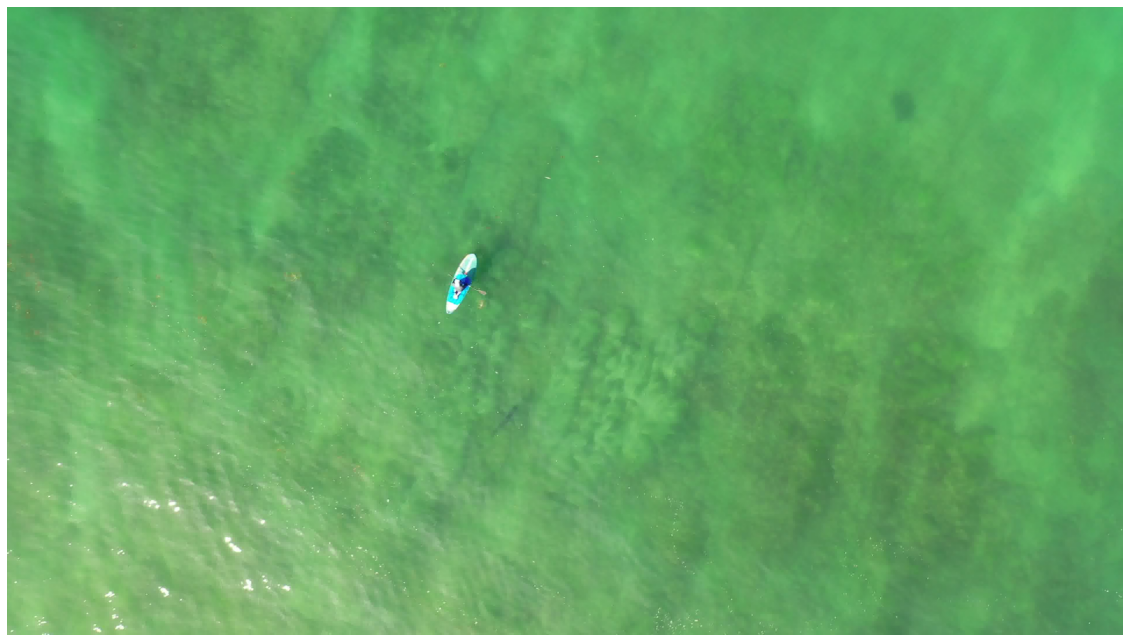

In [15]:
I = io.imread(img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()


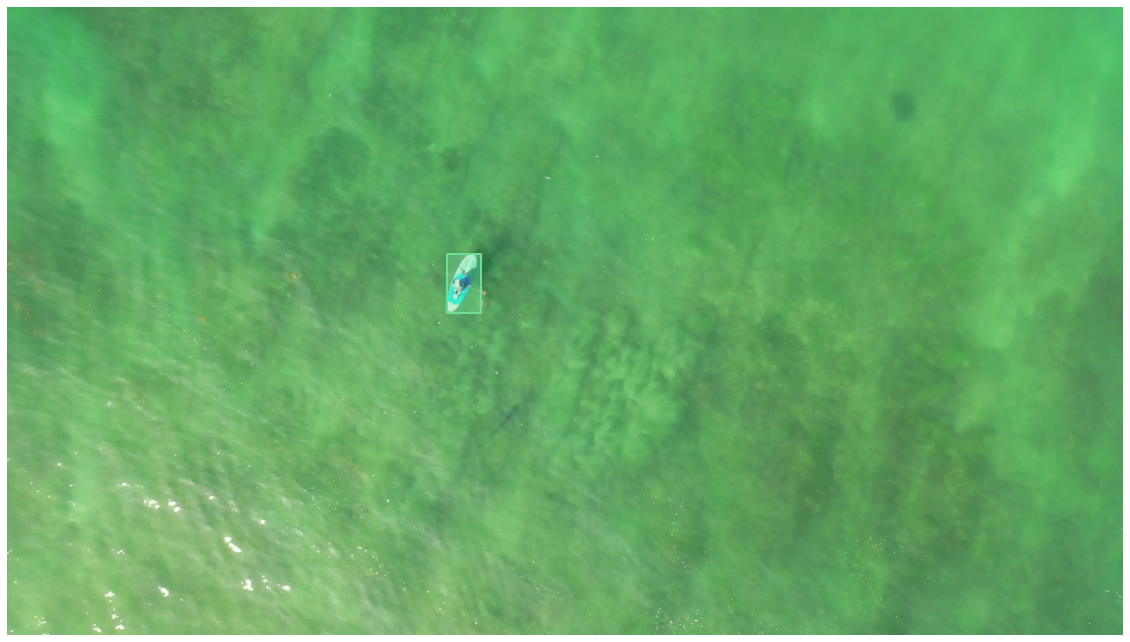

In [17]:
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

# Generating Images to combine as a video

This can take a little longer, especially if we're drawing text & stuff, but this will only save the annotated frames

In [19]:
def generate_annot_images(annFile, img_folder, box_thickness=10, output_folder='test', draw_text=True, 
                            fontScale = 4, color = (36,255,12), # neon green
                            font = cv2.FONT_HERSHEY_SIMPLEX, text_thickness = 10):
    # getting images & frames
    imgs = sorted(os.listdir(img_folder))
    paths = [f'{img_folder}/{f}' for f in imgs]
    assert(int(paths[-1].split('.jpg')[0].split('-')[-1]) == len(paths))
    frame_num = len(paths)
    
    # getting annotations 
    coco=COCO(annFile)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]
    catIds = coco.getCatIds(catNms=nms);
    
    id2catname = {d['id']: d['name'] for d in coco.dataset['categories']}

    # some defaults 
    for i in range(frame_num):
        fn = paths[i]
        image = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
        annIds = coco.getAnnIds(imgIds=i, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        # adding annotations 
        for v in anns:
            rects = np.array(v['bbox']).astype(int)
            s = rects[:2]
            e = rects[:2] + rects[2:]
            image = cv2.rectangle(image, s, e, color, box_thickness)
            # drawing label id 
            if draw_text: 
                text = id2catname[v['category_id']]
                image = cv2.putText(image, text, s - np.array([0,10]),font,
                                    fontScale, color, text_thickness)
        if draw_text and i < 100:
            org = (50,150)
            text = img_folder.split('/')[-1]
            image = cv2.putText(image, text, org, font, fontScale, color, text_thickness)
        
        out_fn = f'{output_folder}/{imgs[i]}'
        if len(anns) >0 and not cv2.imwrite(out_fn, image):
            print(out_fn)

In [25]:
# output folder is where the images w/ bounding boxes r 
generate_labeled_images(fout, frames, output_folder='test')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [24]:
ls test

In [27]:
video_fn

'data/20210910_SUPInteraction.mp4'

In [28]:
# convert all videos in test 
!ffmpeg -framerate 30 -pattern_type glob -i 'test/*.jpg' -c:v libx264 -pix_fmt yuv420p 20210910_SUPInteraction_annot.mp4


ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox
 